In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

In [ ]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

In [ ]:
from llm_toolkit.data_utils import *

data_path = "dataset/amazon_reviews.csv"
results_path = "results/amazon_reviews_results.csv"
num_ctx = os.getenv("NUM_CTX")
data_path, results_path, num_ctx

In [ ]:
import pandas as pd

df = pd.read_csv(results_path)
df.info()

In [ ]:
result_col_start_idx = 3
selected_result_col_start_idx = 3

In [ ]:
model_orders = {
    "deepseek-r1": 80,
    "gpt-4o": 100,
}

In [ ]:
def get_key(model_name):
    parts = model_name.split("/")
    key = f"{model_orders[parts[0]]:03d}/{parts[1]}"
    # print(key)
    return key


result_cols = [
    col
    for col in df.columns[selected_result_col_start_idx:].tolist()
    if col.split("/")[0] in model_orders.keys()
]
result_cols.sort(key=get_key)
result_cols

In [ ]:
result_cols = [
    col
    for col in result_cols
    if "gpt-4o" in col and "40" in col or "deepseek-r1" in col and "30" in col
]
result_cols

In [ ]:
df = df[df.columns[:result_col_start_idx].tolist() + result_cols]

In [ ]:
df.info()

In [ ]:
datasets = prepare_dataset(data_path, "Text", "Review-sentiment")

In [ ]:
metrics = get_metrics(
    df,
    result_col_start_idx=result_col_start_idx,
    mean_eval_time=True,
    train_dataset=datasets["train"],  # , debug=True
)
metrics

In [ ]:
df["Review-sentiment"].value_counts()

In [ ]:
# calc per-class precision/recall - df["Review-sentiment"] is the ground truth
def calc_precision_recall_f1_score(df, col, class_name):
    df["prediction"] = df[col].apply(
        lambda x: extract_answer(x) if isinstance(x, str) else x
    )
    col = "prediction"  # use the prediction column for calculations
    tp = df[(df[col] == class_name) & (df["Review-sentiment"] == class_name)].shape[0]
    fp = df[(df[col] == class_name) & (df["Review-sentiment"] != class_name)].shape[0]
    fn = df[(df[col] != class_name) & (df["Review-sentiment"] == class_name)].shape[0]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # calc f1_score
    f1_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    return precision, recall, f1_score


calc_precision_recall_f1_score(df, result_cols[0], "Strongly Positive")

In [ ]:
import pandas as pd

# We'll collect the results into a list of dicts first
results = []

for row in metrics.iterrows():
    idx = row[0]
    col = result_cols[idx]
    model_name = row[1]["model"]

    for class_name in [
        "Strongly Positive",
        "Positive",
        "Neutral",
        "Negative",
        "Strongly Negative",
    ]:
        precision, recall, f1_score = calc_precision_recall_f1_score(
            df, col, class_name
        )
        results.append(
            {
                "Model": model_name,
                "Class": class_name,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score,
            }
        )

# Now convert results into a dataframe
results_df = pd.DataFrame(results)

# Display the dataframe
results_df

In [ ]:
results_df.to_csv("results/amazon_reviews_precision_recall.csv", index=False)

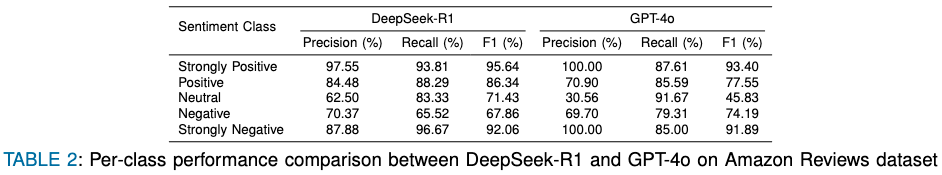